In [1]:
import sys
import os

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    if os.name == 'nt':
        REPO_PATH = "d:/git_project/dinov2"
    elif os.name == 'posix':
        REPO_PATH = "/root/autodl-tmp/dinov2" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

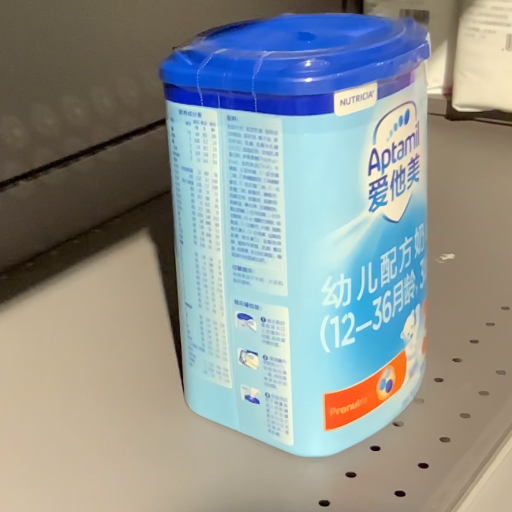

In [2]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

def load_image_from_local(path: str) -> Image:
    with open(path, 'rb') as f:
        return Image.open(f).convert("RGB")

EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


# image = load_image_from_url(EXAMPLE_IMAGE_URL)
if os.name == 'posix':
    path = "/root/autodl-tmp/dinov2/data/test/Onepose/200.png"
elif os.name == 'nt':
    path = "d:/git_project/dinov2/data/test/Linemod/000065.png"
image = load_image_from_local(path)
display(image)

In [3]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

In [4]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_arch, backbone_name

('vits14', 'dinov2_vits14')

In [5]:
if os.name == 'posix':
    path = "/root/.cache/torch/hub/facebookresearch_dinov2_main"
elif os.name == 'nt':
    path = "c:/Users/user/.cache/torch/hub/facebookresearch_dinov2_main"
try:
    backbone_model = torch.hub.load(path, model=backbone_name, source='local')
except:
    backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

/root/autodl-tmp/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/autodl-tmp/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/autodl-tmp/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [6]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 5 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "ade20k" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

head_config_url, head_checkpoint_url

('https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_ade20k_ms_config.py',
 'https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_ade20k_ms_head.pth')

In [7]:
cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/root/miniconda3/envs/dinov2/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-12-01 22:28:52,138 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2023-12-01 22:28:52,145 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([150, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2023-12-01 22:28:52,146 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([150]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2023-12-01 22:28:52,147 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2023-12-01 22:28:52,147 - mmcv - INFO - 
decode_head.bn.bias - torch.Size([153

scales: [1.0, 1.32, 1.73, 2.28, 3.0]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_ade20k_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(1536, 150, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

In [8]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

In [9]:
array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)

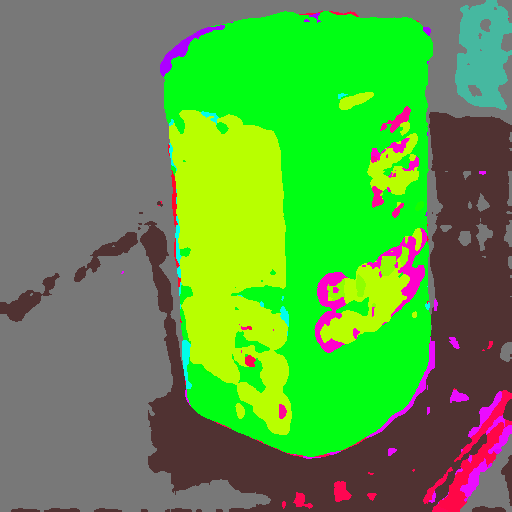

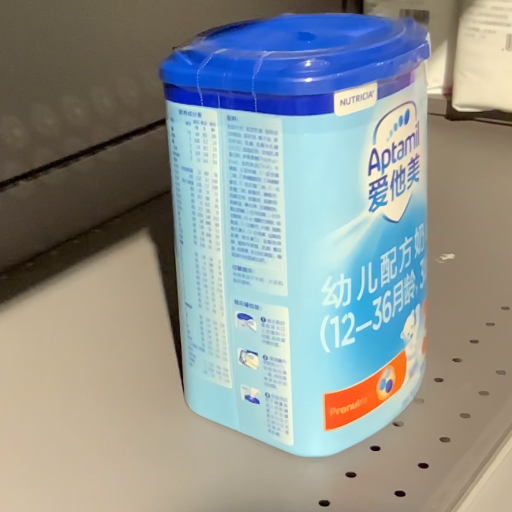

In [10]:
display(segmented_image)
display(image)